In [1]:
#disbale GPU. My poor MX250 with CUDA fails and I do not expect big gains over CPU with my laptop.
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, force CPU mode


# Remove any old TensorFlow installations
#!pip uninstall -y tensorflow tensorflow-gpu
#!pip uninstall -y tf-keras tensorflow-text


# Re-install TensorFlow 2.15.x (this CPU build still includes Keras)
#!pip install --no-cache-dir tensorflow==2.15.0 sionna

import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TF Version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
print("CUDA Available:", tf.test.is_built_with_cuda())
#import mitsuba as mi
#mi.set_variant('scalar_rgb')  # Use CPU mode
!nvidia-smi


GPU Available: []
TF Version: 2.15.0
Available GPUs: []
CUDA Available: True
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
#import - as example in https://nvlabs.github.io/sionna/examples/Sionna_Ray_Tracing_Introduction.html
import os
gpu_num = "0" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.

try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [3]:
#double impoirt - maybe not all needed.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import matplotlib.colors as mcolors


import mitsuba as mi
#mi.set_variant("scalar_rgb")
mi.set_variant('llvm_ad_rgb')  # More compatible CPU mode
#mi.set_variant('cuda_ad_rgb')  #scalar_rgb

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, visualize

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [4]:
# # prompt: Mount drive

# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# prompt: unzip Bergwald_osm.zip foder

!unzip /content/Bergwald_osm.zip -d /content/Bergwald_osm


Archive:  /content/Bergwald_osm.zip
replace /content/Bergwald_osm/Bergwald_osm/Bergwald_osm.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
# #mayde by blender from OSM. 3d buildings from brick and metal roof
# #scene_path = r"/home/dch/gdrive/3. VGTU/VGTU 2024/2. Tyrimai/2. Sionna for RNP/1. Bergwald/Bergwald_osm/Bergwald_osm.xml"
# scene_path = r"/home/dch/Downloads/OSM_building/Bergwald_osm/Bergwald_osm.xml"
# scene = load_scene(scene_path) -- take this file from drive not from linux

# scene_path = (
#     r"/content/drive/MyDrive/3. VGTU/VGTU 2024/2. Tyrimai"
#     r"/2. Sionna for RNP/1. Bergwald/Bergwald_osm/Bergwald_osm.xml"
# )

scene_path = "/content/Bergwald_osm/Bergwald_osm/Bergwald_osm.xml"
scene = load_scene(scene_path)

In [7]:
# #3d preview of buildings
# scene.preview()

In [8]:
#play with adding 3 base stations

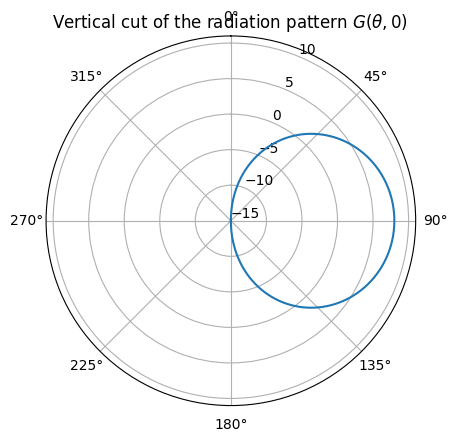

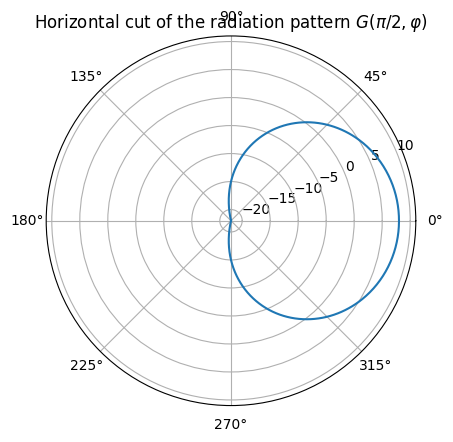

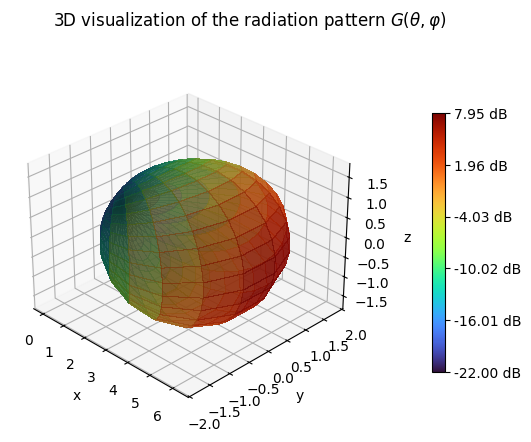

In [9]:
# Configure a 5G 3.5 GHz MIMO 32T panel and assign it to the scene
scene.tx_array = PlanarArray(
    num_rows=4,             # 4 rows
    num_cols=8,             # 8 columns (4x8 = 32T)
    vertical_spacing=0.5,   # Spacing between elements in meters
    horizontal_spacing=0.5,  # Spacing between elements in meters
    pattern="tr38901",      # 3GPP TR 38.901 antenna pattern for 5G
    polarization="VH",      # Vertical and Horizontal polarization
)

# Assign the same antenna array to a variable for visualization
tx_array = scene.tx_array

# Visualize the antenna pattern
fig_v, fig_h, fig_3d = visualize(tx_array.antenna.patterns[0])

# Show the figures
plt.show()

In [10]:
# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create a receiver
rx = Receiver(name="rx_1",
              position=[0,0,1],
              orientation=[0,0,0])
scene.add(rx) #required for coverage map. Any place.

In [11]:
def add_tri_sector_sites(scene, base_stations, tilt_deg=6.0, power_dbm=44.0):
    """
    Adds three transmitters (cells) at each base station position in `base_stations`.

    Each transmitter is oriented at azimuths 0°, 120°, and 240°, with a downward tilt of `tilt_deg`.
    The naming scheme is Site_A_Cell_1, Site_A_Cell_2, Site_A_Cell_3, then Site_B_Cell_1, etc.

    Parameters:
    -----------
    scene : Scene
        The scene to which transmitters are added. Must have a dictionary-like
        `transmitters` attribute.
    base_stations : list of [x, y, z]
        List of positions (floats) for each base station, e.g. [[0,0,30], [50,20,30], ...].
    tilt_deg : float
        Downward tilt in degrees (default 6.0).
    power_dbm : float
        Transmitter power in dBm (default 44.0).
    """

    tilt_down_rad = np.radians(tilt_deg)
    azimuths_deg = [0.0, 120.0, 240.0]  # 3 sectors
    for idx, position in enumerate(base_stations):
        # Convert index 0 -> 'A', 1 -> 'B', etc.
        site_letter = chr(65 + idx)  # 65 is ASCII for 'A'

        for cell_num, az_deg in enumerate(azimuths_deg, start=1):
            az_rad = np.radians(az_deg)
            tx_name = f"Site_{site_letter}_Cell_{cell_num}"

            tx = Transmitter(
                name=tx_name,
                position=tf.Variable(position, dtype=tf.float32),
                orientation=tf.Variable([az_rad, tilt_down_rad, 0.0], dtype=tf.float32),
                power_dbm=tf.Variable(power_dbm, dtype=tf.float32)
            )
            scene.add(tx)

    print(f"Added {len(base_stations)*3} transmitters (3 per site) to the scene.")

def remove_all_transmitters(scene):
    """
    Removes all transmitters from the given scene.
    """
    # Get the list of transmitter names (keys) before modifying the dictionary
    tx_names = list(scene.transmitters.keys())

    # Remove each transmitter by name
    for tx_name in tx_names:
        scene.remove(tx_name)

    print(f"Removed all transmitters. There are now {len(scene.transmitters)} transmitters in the scene.")


In [12]:
height = 30.0
base_stations = [
    [0.0, 0.0, height],
    [-280.0,  -210.0, height],
    [175.0, 190.0, height],
    [280.0, -170.0, height],
    [-280.0, -170.0, height],
    [-280.0, 170.0, height],
    [-140.0, 80.0, height],
    [-140.0, 80.0, height],
]


In [13]:
def generate_base_stations_grid(coverage_width, coverage_height, num_stations, height=30.0):
    """
    Generates a list of base station positions evenly distributed within the coverage area.
    Ensures they are inside the area, avoiding placement at extreme edges.

    Parameters:
        coverage_width (float): Total width of the coverage area.
        coverage_height (float): Total height of the coverage area.
        num_stations (int): Number of base stations to distribute.
        height (float): Fixed height (z-coordinate) for all base stations.

    Returns:
        List of [x, y, z] positions for base stations.
    """
    x_min, x_max = -coverage_width / 2.0, coverage_width / 2.0
    y_min, y_max = -coverage_height / 2.0, coverage_height / 2.0

    # Determine rows and columns for station distribution
    num_rows = int(np.ceil(np.sqrt(num_stations)))
    num_cols = int(np.ceil(num_stations / num_rows))

    # Create evenly spaced x and y coordinates **inside** the area
    x_positions = np.linspace(x_min + coverage_width / (2 * num_cols),
                              x_max - coverage_width / (2 * num_cols), num_cols)

    y_positions = np.linspace(y_min + coverage_height / (2 * num_rows),
                              y_max - coverage_height / (2 * num_rows), num_rows)

    # Generate grid positions inside the area
    base_stations = []
    for i, x in enumerate(x_positions):
        for j, y in enumerate(y_positions):
            if len(base_stations) < num_stations:
                base_stations.append([x, y, height])

    return base_stations


In [14]:
coverage_width, coverage_height = 900, 800  # Example values from cm_los.size
num_stations =12  # Number of base stations
height = 30.0

base_stations = generate_base_stations_grid(coverage_width, coverage_height, num_stations, height)

# Print generated base station positions
for i, pos in enumerate(base_stations):
    print(f"Base Station {i+1}: {pos}")


Base Station 1: [-300.0, -300.0, 30.0]
Base Station 2: [-300.0, -100.0, 30.0]
Base Station 3: [-300.0, 100.0, 30.0]
Base Station 4: [-300.0, 300.0, 30.0]
Base Station 5: [0.0, -300.0, 30.0]
Base Station 6: [0.0, -100.0, 30.0]
Base Station 7: [0.0, 100.0, 30.0]
Base Station 8: [0.0, 300.0, 30.0]
Base Station 9: [300.0, -300.0, 30.0]
Base Station 10: [300.0, -100.0, 30.0]
Base Station 11: [300.0, 100.0, 30.0]
Base Station 12: [300.0, 300.0, 30.0]


In [15]:
#3d preview of buildings
remove_all_transmitters(scene)
add_tri_sector_sites(scene, base_stations, tilt_deg=6.0, power_dbm=37.0)
#scene.preview(show_orientations=True)

Removed all transmitters. There are now 0 transmitters in the scene.
Added 36 transmitters (3 per site) to the scene.


In [16]:
scene.frequency = 3.5e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

# Create new camera
bird_pos = [0, 0, 0]
bird_pos[-1] = 1500 # Set height of coverage map to 1000m above tx
bird_pos[-2]-= 0.01 # Slightly move the camera for correct orientation

# Create new camera
bird_cam = Camera("birds_view", position=bird_pos, look_at=[0, 0, 0])
scene.add(bird_cam)


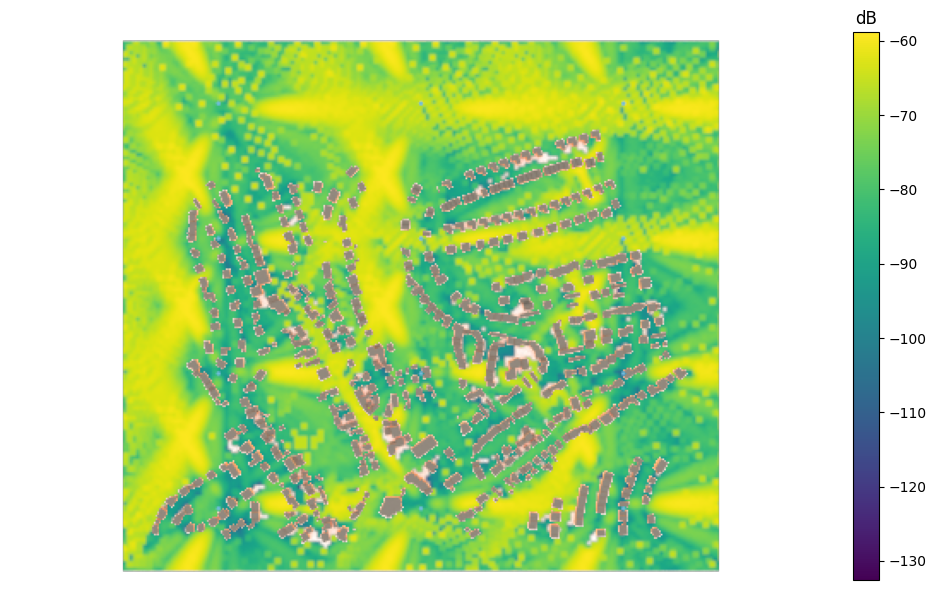

In [17]:
cm_los = scene.coverage_map(max_depth=5,
                        los=True, reflection=False, diffraction=False, scattering=False,
                        cm_cell_size=(5., 5.), # Grid size of coverage map cells in m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(5e6) #20e6
                           )

scene.render(camera="birds_view", coverage_map=cm_los, num_samples=512, resolution=resolution, show_devices=True);


In [18]:
#3d preview of buildings
#scene.preview(show_orientations=True,coverage_map=cm_los)

[INFO] Coverage grid shape: (160, 180)
[INFO] Coverage total size (m): 900.0 800.0
[INFO] Coverage cell size (m): 5.0 5.0
[INFO] Saved coverage to 'coverage_map_all_txs_all_properties.csv'.
[INFO] Number of base stations: 12
[INFO] Percentage of area covered by 3 or more base stations: 25.80%


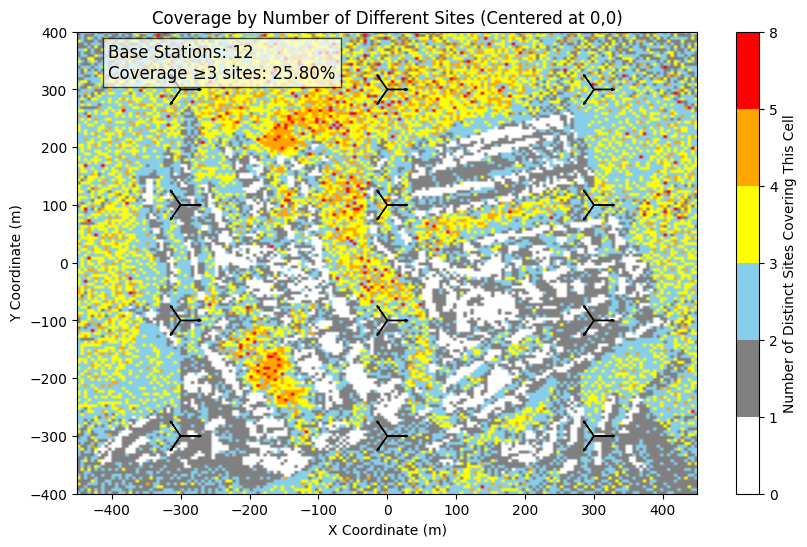

[INFO] Coverage map with center at (0,0) complete.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf

###############################################################################
# 0) GET COVERAGE DIMENSIONS FROM cm_los
###############################################################################
num_cells_y, num_cells_x = cm_los.rss[0].shape
coverage_width, coverage_height = cm_los.size.numpy()  # e.g. 900, 800
cell_size_x, cell_size_y = cm_los.cell_size.numpy()    # e.g. 5, 5

print("[INFO] Coverage grid shape:", (num_cells_y, num_cells_x))
print("[INFO] Coverage total size (m):", coverage_width, coverage_height)
print("[INFO] Coverage cell size (m):", cell_size_x, cell_size_y)

###############################################################################
# 1) DEFINE A COVERAGE GRID CENTERED AT (0,0)
###############################################################################
# We'll define x from -coverage_width/2 to +coverage_width/2
# and y from -coverage_height/2 to +coverage_height/2
x_min = -coverage_width / 2.0
x_max = +coverage_width / 2.0
y_min = -coverage_height / 2.0
y_max = +coverage_height / 2.0

# Create linearly spaced coordinates with num_cells_x / num_cells_y steps
x_coords = np.linspace(x_min, x_max, num_cells_x)
y_coords = np.linspace(y_min, y_max, num_cells_y)

# Build the 2D mesh and flatten for DataFrame
X, Y = np.meshgrid(x_coords, y_coords)  # shape: (num_cells_y, num_cells_x)
x_coords_flat = X.flatten()
y_coords_flat = Y.flatten()

###############################################################################
# 2) COMBINE PER-TRANSMITTER COVERAGE INTO A SINGLE DATAFRAME
###############################################################################
num_tx = cm_los.rss.shape[0]

df_list = []
for tx_index in range(num_tx):
    # Flatten the coverage array for this transmitter
    rss_flat = cm_los.rss[tx_index].numpy().flatten()
    data = {
        'x': x_coords_flat,
        'y': y_coords_flat,
        'tx_index': tx_index,
        'RSS (dB)': rss_flat
    }
    if hasattr(cm_los, 'path_gain'):
        data['Path Gain (dB)'] = cm_los.path_gain[tx_index].numpy().flatten()
    if hasattr(cm_los, 'sinr'):
        data['SINR (dB)'] = cm_los.sinr[tx_index].numpy().flatten()

    df_list.append(pd.DataFrame(data))

df_all = pd.concat(df_list, ignore_index=True)
df_all.to_csv("coverage_map_all_txs_all_properties.csv", index=False)
print("[INFO] Saved coverage to 'coverage_map_all_txs_all_properties.csv'.")

###############################################################################
# 3) LINK tx_index → TRANSMITTER NAME, EXTRACT SITE NAME
###############################################################################
tx_names_in_order = list(scene.transmitters.keys())

def extract_site_name(tx_name):
    # e.g. "Site_A_Cell_2" -> "Site_A"
    return tx_name.split("_Cell_")[0]

index_to_site = {}
for i, tx_name in enumerate(tx_names_in_order):
    index_to_site[i] = extract_site_name(tx_name)

df_all["site_name"] = df_all["tx_index"].apply(lambda idx: index_to_site[idx])

###############################################################################
# 4) AGGREGATE COVERAGE PER SITE (TAKE MAX RSS AT EACH (x,y))
###############################################################################
df_site = df_all.groupby(["site_name","x","y"], as_index=False)["RSS (dB)"].max()

# Suppose coverage means "RSS(dB) > 0"
df_site["covered"] = df_site["RSS (dB)"] > 0
df_site_covered = df_site[df_site["covered"]]

# Count how many sites cover each cell
counts_by_xy = df_site_covered.groupby(["x","y"]).size().reset_index(name="site_count")

###############################################################################
# 5) BUILD 2D ARRAY (site_count_grid) FOR PLOTTING
###############################################################################
dict_xy_to_count = {
    (row.x,row.y): row.site_count
    for row in counts_by_xy.itertuples(index=False)
}

site_count_grid = np.zeros((num_cells_y, num_cells_x))
for i in range(num_cells_y):
    for j in range(num_cells_x):
        xy_key = (X[i, j], Y[i, j])
        if xy_key in dict_xy_to_count:
            site_count_grid[i, j] = dict_xy_to_count[xy_key]

###############################################################################
# 6) DEFINE A DISCRETE COLOR MAP (UP TO 6, THEN 7+)
###############################################################################
colors = [
    "white",      # 0
    "gray",       # 1
    "skyblue",    # 2
    "yellow",     # 3
    "orange",     # 4
    "red",        # 5
    # "firebrick",  # 6
    # "darkred"     # 7+
]
cmap = mcolors.ListedColormap(colors)

max_sites = int(site_count_grid.max())
if max_sites < 5:
    levels = np.arange(0, max_sites + 2)
else:
    levels = [0,1,2,3,4,5, max_sites+1]

norm = mcolors.BoundaryNorm(levels, len(colors))

###############################################################################
# 7) PLOT THE COVERAGE MAP CENTERED AT (0,0)
###############################################################################
plt.figure(figsize=(10, 6))

plt.imshow(site_count_grid,
           cmap=cmap, norm=norm,
           origin='lower', aspect='auto',
           extent=[x_min, x_max, y_min, y_max])

plt.colorbar(label='Number of Distinct Sites Covering This Cell')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.title('Coverage by Number of Different Sites (Centered at 0,0)')

###############################################################################
# 8) OPTIONAL: PLOT TRANSMITTER ARROWS
###############################################################################
def plot_tx_arrows(scene, arrow_length=10, scale_factor=2):
    """
    Plots each transmitter in the scene as an arrow indicating its azimuth.
    The arrow size is adjusted for better visibility.

    Parameters:
        scene: The scene object containing transmitters.
        arrow_length: Base length of the arrow.
        scale_factor: Multiplier to increase arrow body length.
    """
    for tx_name, tx in scene.transmitters.items():
        pos = tx.position.numpy()       # [x, y, z]
        orient = tx.orientation.numpy() # [azimuth(rad), tilt(rad), roll(rad)]
        azimuth = orient[0]

        # Increase arrow body length using scale_factor
        dx = scale_factor * arrow_length * np.cos(azimuth)
        dy = scale_factor * arrow_length * np.sin(azimuth)

        plt.arrow(pos[0], pos[1], dx, dy,
                  head_width=3.0, head_length=4.0,  # Increased for visibility
                  fc='black', ec='black', length_includes_head=True)

        # Optional: label near arrow tip
        # plt.text(pos[0]+dx, pos[1]+dy, tx_name, color='black', fontsize=10)

plot_tx_arrows(scene, arrow_length=10, scale_factor=3)

# SAVE + SHOW
plt.savefig("coverage_map_centered.png", dpi=300, bbox_inches='tight')

###############################################################################
# 9) CALCULATE PERCENTAGE AREA COVERED BY 3 OR MORE BASE STATIONS
###############################################################################
# Count cells where 3 or more base stations provide coverage
num_cells_covered_by_3_or_more = np.sum(site_count_grid >= 3)

# Total number of coverage cells
total_cells = num_cells_y * num_cells_x

# Compute percentage
coverage_percentage = (num_cells_covered_by_3_or_more / total_cells) * 100

# Count number of unique base stations (site names)
num_base_stations = len(set(extract_site_name(tx_name) for tx_name in scene.transmitters.keys()))

# Print the results
print(f"[INFO] Number of base stations: {num_base_stations}")
print(f"[INFO] Percentage of area covered by 3 or more base stations: {coverage_percentage:.2f}%")

# Annotate on the plot
plt.text(x_min + 0.05 * coverage_width, y_max - 0.1 * coverage_height,
         f"Base Stations: {num_base_stations}\nCoverage ≥3 sites: {coverage_percentage:.2f}%",
         fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.7))

# SAVE + SHOW
plt.savefig("coverage_map_centered.png", dpi=300, bbox_inches='tight')
plt.show()

print("[INFO] Coverage map with center at (0,0) complete.")



In [20]:
#scene.preview(show_orientations=True, coverage_map=cm_los)

In [21]:
df_site.to_csv("Coverage_by_site.csv", index=False)

In [22]:
counts_by_xy.to_csv("counts_of_sites_by_xy.csv", index=False)

In [23]:
def convert_local_xy_to_latlon(df_in,
                               x_min=-450, x_max=450,
                               y_min=-400, y_max=400,
                               lat_min=48.967, lat_max=48.973,
                               lon_min=8.4737, lon_max=8.4849):
    """
    Takes a DataFrame with columns 'x' and 'y' (local coordinates),
    converts them to lat/lon, and returns a new DataFrame with
    additional 'lat' and 'lon' columns.

    Parameters
    ----------
    df_in : pd.DataFrame
        Must contain at least 'x' and 'y' columns.
    x_min, x_max : float
        Range of the local x-coordinates to be mapped.
    y_min, y_max : float
        Range of the local y-coordinates to be mapped.
    lat_min, lat_max : float
        Latitude range for the mapping.
    lon_min, lon_max : float
        Longitude range for the mapping.

    Returns
    -------
    df_out : pd.DataFrame
        A copy of the original DataFrame with new 'lat' and 'lon' columns.
    """

    df_out = df_in.copy()

    # Affine transform for longitude
    df_out['lon'] = lon_min + (df_out['x'] - x_min) * (lon_max - lon_min) / (x_max - x_min)

    # Affine transform for latitude
    df_out['lat'] = lat_min + (df_out['y'] - y_min) * (lat_max - lat_min) / (y_max - y_min)

    return df_out


In [24]:

df_with_latlon = convert_local_xy_to_latlon(counts_by_xy)
#print(df_with_latlon)


In [25]:
df_with_latlon.to_csv("counts_of_sites_by_lonlat_5x5.csv", index=False)

In [26]:
base_stations_df = pd.DataFrame(base_stations, columns=['x', 'y', 'z'])
base_stations_df

,x,y,z
0,-300.0,-300.0,30.0
1,-300.0,-100.0,30.0
2,-300.0,100.0,30.0
3,-300.0,300.0,30.0
4,0.0,-300.0,30.0
5,0.0,-100.0,30.0
6,0.0,100.0,30.0
7,0.0,300.0,30.0
8,300.0,-300.0,30.0
9,300.0,-100.0,30.0


In [27]:

base_stations_latlon = convert_local_xy_to_latlon(base_stations_df)
base_stations_latlon.to_csv("base_stations_latlon_5x5.csv", index=False)